In [1]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import time
import math
import sys
import matplotlib.pyplot as plt

sys.path.append(os.path.join('..','..'))
import EnergyPricesLibrary as Ep
import CustomMetrics

from kerastuner.tuners import BayesianOptimization
from sklearn.metrics import mean_squared_error

%load_ext autoreload
%autoreload 2

In [2]:
def build_model_concat(hourly_input_shape,daily_input_shape,n_steps_out=24):
    
    input_1 = tf.keras.layers.Input(shape=hourly_input_shape)
    input_2 = tf.keras.layers.Input(shape=daily_input_shape)

    model_1_1 = tf.keras.layers.GRU(units=448,activation='tanh',kernel_regularizer=tf.keras.regularizers.L1(l1=0.06),dropout=0.36,return_sequences=True)(input_1)
    model_1_1 = tf.keras.layers.GRU(units=128,activation='tanh',kernel_regularizer=tf.keras.regularizers.L1(l1=0.09),dropout=0.36,return_sequences=False)(model_1_1)
    model_1_1 = tf.keras.layers.Dense(units=n_steps_out,activation='relu')(model_1_1)

    model_2_2 = tf.keras.layers.GRU(units=256,activation='tanh',kernel_regularizer=tf.keras.regularizers.L1(l1=0),dropout=0,return_sequences=True)(input_2)
    model_2_2 = tf.keras.layers.GRU(units=512,activation='tanh',kernel_regularizer=tf.keras.regularizers.L1(l1=0),dropout=0,return_sequences=True)(model_2_2)
    model_2_2 = tf.keras.layers.Flatten()(model_2_2)
    model_2_2 = tf.keras.layers.Dense(units=n_steps_out,activation='relu')(model_2_2)

    output = tf.keras.layers.Concatenate()([model_1_1, model_2_2])
    output = tf.keras.layers.Dense(units=96,activation='relu')(output)
    output = tf.keras.layers.Dense(units=96,activation='relu')(output)
    
    output = tf.keras.layers.Dense(units=n_steps_out,activation=None)(output)

    full_model = tf.keras.Model(inputs=[input_1, input_2], outputs=[output])
    
    return full_model

def build_model_sum(hourly_input_shape,daily_input_shape,n_steps_out=24):
    
    input_1 = tf.keras.layers.Input(shape=hourly_input_shape)
    input_2 = tf.keras.layers.Input(shape=daily_input_shape)

    model_1_1 = tf.keras.layers.GRU(units=448,activation='tanh',kernel_regularizer=tf.keras.regularizers.L1(l1=0.06),dropout=0.36,return_sequences=True)(input_1)
    model_1_1 = tf.keras.layers.GRU(units=128,activation='tanh',kernel_regularizer=tf.keras.regularizers.L1(l1=0.09),dropout=0.36,return_sequences=False)(model_1_1)
    model_1_1 = tf.keras.layers.Dense(units=n_steps_out,activation=None)(model_1_1)

    model_2_2 = tf.keras.layers.GRU(units=256,activation='tanh',kernel_regularizer=tf.keras.regularizers.L1(l1=0),dropout=0,return_sequences=True)(input_2)
    model_2_2 = tf.keras.layers.GRU(units=512,activation='tanh',kernel_regularizer=tf.keras.regularizers.L1(l1=0),dropout=0,return_sequences=True)(model_2_2)
    model_2_2 = tf.keras.layers.Flatten()(model_2_2)
    model_2_2 = tf.keras.layers.Dense(units=n_steps_out,activation=None)(model_2_2)

    output = tf.keras.layers.Add()([model_1_1, model_2_2])
    
    output = tf.keras.layers.Dense(units=n_steps_out,activation=None)(output)

    full_model = tf.keras.Model(inputs=[input_1, input_2], outputs=[output])
    
    return full_model

"""
def make_predictions(model,scaler_D_x,scaler_D_y,scaler_H_x,scaler_H_y,
                     trainX_D, trainY_D, testX_D, testY_D,
                     trainX_H, trainY_H, testX_H, testY_H,
                     n_steps_out,len_output_features):
""" 
def make_predictions(model,scaler_D_y,trainX_H,trainX_D,testX_H,testX_D,
                     trainY_D,testY_D,n_steps_out,len_output_features):
    
    # make predictions
    trainPredict = model.predict([trainX_H,trainX_D])
    trainPredict = trainPredict.reshape(trainPredict.shape[0]*n_steps_out,len_output_features)
    testPredict  = model.predict([testX_H,testX_D])
    testPredict  = testPredict.reshape(testPredict.shape[0]*n_steps_out,len_output_features)
    
    # invert predictions
    trainPredict = scaler_D_y.inverse_transform(trainPredict)
    trainY = scaler_D_y.inverse_transform(trainY_D.reshape(trainY_D.shape[0]*n_steps_out,len_output_features))
    
    testPredict = scaler_D_y.inverse_transform(testPredict)
    testY = scaler_D_y.inverse_transform(testY_D.reshape(testY_D.shape[0]*n_steps_out,len_output_features))
        
    return trainPredict,trainY,testPredict,testY

def get_metrics(trainY,trainPredict,testY,testPredict):
    
    trainMAPE  = Ep.MAPE(trainPredict,trainY)
    testMAPE  = Ep.MAPE(testPredict,testY)
    
    train_sMAPE  = Ep.sMAPE(trainY,trainPredict)
    test_sMAPE  = Ep.sMAPE(testY,testPredict)
    
    return trainMAPE,testMAPE,train_sMAPE,test_sMAPE

In [3]:
data_diaria_path = os.path.join('..','..','..','..','dataset','Series','Sabanas','Original','Sabana_Datos_Diaria.xlsx')
data_diaria = pd.read_excel(data_diaria_path)
data_diaria = data_diaria.set_index('Fecha')

In [4]:
data_horaria_path = os.path.join('..','..','..','..','dataset','Series','Sabanas','Original','Sabana_Datos_Horaria.xlsx')
data_horaria = pd.read_excel(data_horaria_path)
data_horaria = data_horaria.set_index('Fecha')

In [5]:
precio_bolsa_path = os.path.join('..','..','..','..','dataset','Series','Sabanas','Original','Sabana_Datos_Precio_Bolsa.xlsx')
precio_bolsa = pd.read_excel(precio_bolsa_path)
precio_bolsa = precio_bolsa.set_index('Fecha')

In [6]:
nombre_series_diaria = data_diaria.columns.values
nombre_series_horaria = data_horaria.columns.values

In [7]:
data_horaria_full = pd.concat([data_horaria,precio_bolsa],axis=1)

In [8]:
data_horaria.shape,data_diaria.shape, precio_bolsa.shape

((177480, 85), (7395, 119), (177480, 1))

## Build Window

In [9]:
d = 'All'
start_date_train = '2000-02-01'
start_date_val = '2020-01-01'
start_date_test = '2020-04-01'
end_date_test = '2020-05-01'
n_steps_out=24
output_columns = ['$kWh']

In [10]:
n_steps_in = 5
overlap = 1
inputs_columns = nombre_series_diaria

len_input_features = len(inputs_columns)
len_output_features = len(output_columns)

results = Ep.SplitTimeseriesMultipleTimesBackAhead_differentTimes(df_x=data_diaria,
                                                                  df_y=precio_bolsa,
                                                                  day=d,
                                                                  start_date_train=start_date_train,start_date_val=start_date_val,
                                                                  start_date_test=start_date_test,end_date_test=end_date_test,
                                                                  n_steps_out=n_steps_out,n_steps_in=n_steps_in,
                                                                  overlap=overlap,input_features=inputs_columns,
                                                                  output_features=output_columns)

trainX_D,trainY_D,valX_D,valY_D,testX_D,testY_D,scaler_D_x,scaler_D_y,dataset_x_D, dataset_y_D = results

In [11]:
n_steps_in = 120
overlap = 24
inputs_columns = nombre_series_horaria

len_input_features = len(inputs_columns)
len_output_features = len(output_columns)

results = Ep.SplitTimeseriesMultipleTimesBackAhead(df=data_horaria_full,
                                                   day=d,
                                                   start_date_train=start_date_train,start_date_val=start_date_val,
                                                   start_date_test=start_date_test,end_date_test=end_date_test,
                                                   n_steps_out=n_steps_out,n_steps_in=n_steps_in,overlap=overlap,
                                                   input_features=inputs_columns,output_features=output_columns)

trainX_H,trainY_H,valX_H,valY_H,testX_H,testY_H,scaler_H_x,scaler_H_y,dataset_x_H, dataset_y_H = results

### Train

In [12]:
'Diaria:',trainX_D.shape,trainY_D.shape,'Horaria:',trainX_H.shape, trainY_H.shape

('Diaria:',
 (7269, 5, 119),
 (7269, 24, 1),
 'Horaria:',
 (7269, 120, 85),
 (7269, 24, 1))

In [13]:
'Diaria:',valX_D.shape,valY_D.shape,'Horaria:',valX_H.shape,valY_H.shape

('Diaria:', (91, 5, 119), (91, 24, 1), 'Horaria:', (91, 120, 85), (91, 24, 1))

In [14]:
trainX_D = np.concatenate([trainX_D,valX_D])
trainY_D = np.concatenate([trainY_D,valY_D])

trainX_H = np.concatenate([trainX_H,valX_H])
trainY_H = np.concatenate([trainY_H,valY_H])

In [15]:
'Diaria:',trainX_D.shape, trainY_D.shape,'Horaria:',trainX_H.shape, trainY_H.shape

('Diaria:',
 (7360, 5, 119),
 (7360, 24, 1),
 'Horaria:',
 (7360, 120, 85),
 (7360, 24, 1))

### Test

In [16]:
'Diaria:',testX_D.shape, testY_D.shape,'Horaria:',testX_H.shape, testY_H.shape,'Imagenes:'

('Diaria:',
 (30, 5, 119),
 (30, 24, 1),
 'Horaria:',
 (30, 120, 85),
 (30, 24, 1),
 'Imagenes:')

## Model

In [17]:
"""
log_dir = os.path.join('logs','ModeloCompleto_I5_Sum-DenseTanhRelu')
if not os.path.exists(log_dir):
    os.makedirs(log_dir)
callback_tensorboard = tf.keras.callbacks.TensorBoard(log_dir=log_dir,
                                                          histogram_freq=2,
                                                          write_graph=True,
                                                          update_freq='epoch')
"""

callback_reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',
                                                          factor=0.1,
                                                          min_lr=1e-5,
                                                          patience=5,
                                                          verbose=1)

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                  patience=10,
                                                  mode='min')

#callbacks = [callback_reduce_lr,early_stopping,callback_tensorboard]
callbacks = [callback_reduce_lr,early_stopping]

In [18]:
hourly_input_shape = (trainX_H.shape[1],trainX_H.shape[2])
daily_input_shape = (trainX_D.shape[1],trainX_D.shape[2])

model = build_model_sum(hourly_input_shape,daily_input_shape)

model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 5, 119)]     0                                            
__________________________________________________________________________________________________
input_1 (InputLayer)            [(None, 120, 85)]    0                                            
__________________________________________________________________________________________________
gru_2 (GRU)                     (None, 5, 256)       289536      input_2[0][0]                    
__________________________________________________________________________________________________
gru (GRU)                       (None, 120, 448)     719040      input_1[0][0]                    
_______________________________________________________________________________________

In [19]:
model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.00035860735981893),
              loss=CustomMetrics.symmetric_mean_absolute_percentage_error,
              metrics=[tf.metrics.MeanAbsoluteError(),
                       tf.keras.metrics.MeanAbsolutePercentageError(),
                       CustomMetrics.symmetric_mean_absolute_percentage_error])

In [20]:
"""
import json

model_json = model.to_json()
with open("ModeloCompleto_I15_Sum-2.json", "w") as json_file:
    json_file.write(model_json)
"""

'\nimport json\n\nmodel_json = model.to_json()\nwith open("ModeloCompleto_I15_Sum-2.json", "w") as json_file:\n    json_file.write(model_json)\n'

In [21]:
model.fit([trainX_H,trainX_D], trainY_D, validation_data=([testX_H,testX_D],testY_D),
               epochs=200,callbacks=callbacks,verbose=1)

Epoch 1/200
230/230 [==============================] - 10s 45ms/step - loss: 4160.5864 - mean_absolute_error: 0.1566 - mean_absolute_percentage_error: 20471.8848 - symmetric_mean_absolute_percentage_error: 3410.5269 - val_loss: 4654.8374 - val_mean_absolute_error: 0.7227 - val_mean_absolute_percentage_error: 924.6926 - val_symmetric_mean_absolute_percentage_error: 4014.3958
Epoch 2/200
230/230 [==============================] - 9s 39ms/step - loss: 2907.4060 - mean_absolute_error: 0.0533 - mean_absolute_percentage_error: 7748.2944 - symmetric_mean_absolute_percentage_error: 2345.3994 - val_loss: 3925.1790 - val_mean_absolute_error: 0.3614 - val_mean_absolute_percentage_error: 461.3232 - val_symmetric_mean_absolute_percentage_error: 3431.0095
Epoch 3/200
230/230 [==============================] - 9s 40ms/step - loss: 2046.8713 - mean_absolute_error: 0.0267 - mean_absolute_percentage_error: 4137.2236 - symmetric_mean_absolute_percentage_error: 1601.3962 - val_loss: 3119.2366 - val_mean_a

Epoch 22/200
230/230 [==============================] - 9s 40ms/step - loss: 787.7402 - mean_absolute_error: 0.0100 - mean_absolute_percentage_error: 1062.1073 - symmetric_mean_absolute_percentage_error: 630.4230 - val_loss: 1526.0021 - val_mean_absolute_error: 0.0571 - val_mean_absolute_percentage_error: 74.0805 - val_symmetric_mean_absolute_percentage_error: 1372.0229
Epoch 23/200
230/230 [==============================] - 9s 40ms/step - loss: 768.6440 - mean_absolute_error: 0.0099 - mean_absolute_percentage_error: 1112.8147 - symmetric_mean_absolute_percentage_error: 618.8568 - val_loss: 862.0921 - val_mean_absolute_error: 0.0269 - val_mean_absolute_percentage_error: 35.4702 - val_symmetric_mean_absolute_percentage_error: 716.6703
Epoch 24/200
230/230 [==============================] - 9s 40ms/step - loss: 761.7050 - mean_absolute_error: 0.0098 - mean_absolute_percentage_error: 950.6599 - symmetric_mean_absolute_percentage_error: 619.8956 - val_loss: 1423.4034 - val_mean_absolute_er

230/230 [==============================] - 9s 40ms/step - loss: 543.7296 - mean_absolute_error: 0.0079 - mean_absolute_percentage_error: 977.2802 - symmetric_mean_absolute_percentage_error: 519.9340 - val_loss: 707.2247 - val_mean_absolute_error: 0.0208 - val_mean_absolute_percentage_error: 23.9997 - val_symmetric_mean_absolute_percentage_error: 683.8988
Epoch 45/200
230/230 [==============================] - 9s 40ms/step - loss: 545.8095 - mean_absolute_error: 0.0079 - mean_absolute_percentage_error: 1089.5768 - symmetric_mean_absolute_percentage_error: 523.0555 - val_loss: 553.7138 - val_mean_absolute_error: 0.0191 - val_mean_absolute_percentage_error: 25.3139 - val_symmetric_mean_absolute_percentage_error: 531.6379
Epoch 46/200
230/230 [==============================] - 9s 40ms/step - loss: 539.0052 - mean_absolute_error: 0.0078 - mean_absolute_percentage_error: 1059.5483 - symmetric_mean_absolute_percentage_error: 517.7463 - val_loss: 489.1447 - val_mean_absolute_error: 0.0165 - va

230/230 [==============================] - 9s 40ms/step - loss: 443.7973 - mean_absolute_error: 0.0063 - mean_absolute_percentage_error: 947.2026 - symmetric_mean_absolute_percentage_error: 432.0833 - val_loss: 411.6725 - val_mean_absolute_error: 0.0142 - val_mean_absolute_percentage_error: 17.1790 - val_symmetric_mean_absolute_percentage_error: 400.0176
Epoch 66/200
230/230 [==============================] - 9s 40ms/step - loss: 443.8228 - mean_absolute_error: 0.0063 - mean_absolute_percentage_error: 933.8896 - symmetric_mean_absolute_percentage_error: 432.2191 - val_loss: 402.2191 - val_mean_absolute_error: 0.0138 - val_mean_absolute_percentage_error: 16.9462 - val_symmetric_mean_absolute_percentage_error: 390.6372
Epoch 67/200
230/230 [==============================] - 9s 40ms/step - loss: 440.8802 - mean_absolute_error: 0.0063 - mean_absolute_percentage_error: 873.2113 - symmetric_mean_absolute_percentage_error: 429.2972 - val_loss: 378.3740 - val_mean_absolute_error: 0.0129 - val_

### Validación

In [22]:
model.evaluate(x=[testX_H,testX_D], y=testY_D)

1/1 [==============================] - 0s 3ms/step - loss: 391.6590 - mean_absolute_error: 0.0132 - mean_absolute_percentage_error: 16.4732 - symmetric_mean_absolute_percentage_error: 380.9545


[391.6590270996094, 0.01319642923772335, 16.473234176635742, 380.9544982910156]

In [23]:
"""
trainPredict,trainY,testPredict,testY = make_predictions(model,scaler_D_x,scaler_D_y,scaler_H_x,scaler_H_y,
                                                         trainX_D, trainY_D, testX_D, testY_D,
                                                         trainX_H, trainY_H, testX_H, testY_H,
                                                         n_steps_out,len_output_features)
"""

trainPredict,trainY,testPredict,testY = make_predictions(model=model,
                                                         scaler_D_y=scaler_D_y,
                                                         trainX_H=trainX_H,
                                                         trainX_D=trainX_D,
                                                         testX_H=testX_H,
                                                         testX_D=testX_D,
                                                         trainY_D=trainY_D,
                                                         testY_D=testY_D,
                                                         n_steps_out=n_steps_out,
                                                         len_output_features=len_output_features)

In [24]:
trainPredict.shape,trainY.shape,testPredict.shape,testY.shape

((176640, 1), (176640, 1), (720, 1), (720, 1))

In [25]:
trainMAPE,testMAPE,train_sMAPE,test_sMAPE = get_metrics(trainY,trainPredict,testY,testPredict)

In [26]:
trainMAPE,testMAPE,train_sMAPE,test_sMAPE

(0.1258452238386369,
 0.14914933679544326,
 12.203755438376682,
 14.475894469349287)

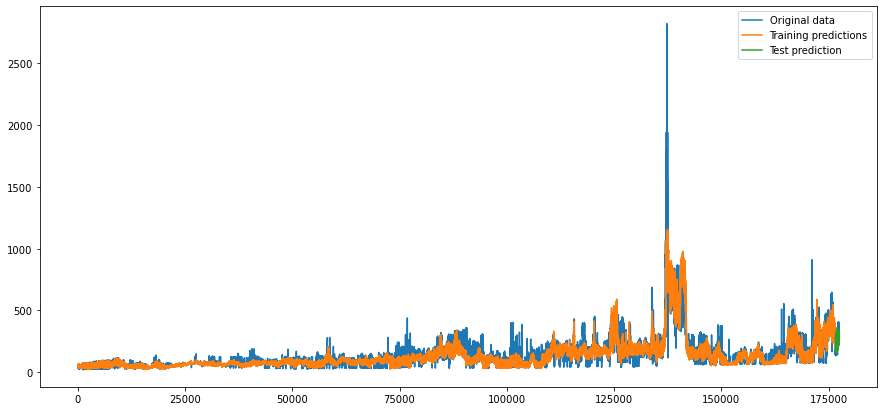

In [27]:
Nt = trainPredict.shape[0] + testPredict.shape[0]
trainPredictPlot = np.zeros((Nt,1))
trainPredictPlot[:,:] = np.nan
trainPredictPlot[:len(trainPredict), :] = np.concatenate((dataset_y_D[0].reshape(1,1),trainPredict[:-1]))

# shift test predictions for plotting
testPredictPlot = np.zeros((Nt,1))
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict):Nt, :] = testPredict

plt.figure(figsize=(15,7))
plt.plot(np.concatenate((trainY,testY)),label='Original data')
plt.plot(trainPredictPlot,label='Training predictions')
plt.plot(testPredictPlot,label='Test prediction')
plt.legend()
plt.show()

In [28]:
testOriginalPlot = np.zeros((testY.shape[0],1))
testOriginalPlot[:, :] = testY

testPredictPlot = np.zeros((testPredict.shape[0],1))
testPredictPlot[:, :] = testPredict

In [29]:
testOriginalPlot.shape,testY.shape,testPredict.shape

((720, 1), (720, 1), (720, 1))

In [30]:
test_size = testY.shape[0]
precio_bolsa_test = precio_bolsa[-test_size:]
precio_bolsa_test = precio_bolsa_test.copy()
precio_bolsa_test['day_of_week']  = precio_bolsa_test.index.day_name()
precio_bolsa_test['date']  = precio_bolsa_test.index.date
precio_bolsa_test['idx'] = np.arange(len(precio_bolsa_test))

Days = np.array(['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday'])
day_color = ['red','orange','green','purple','gold','deeppink','saddlebrown']

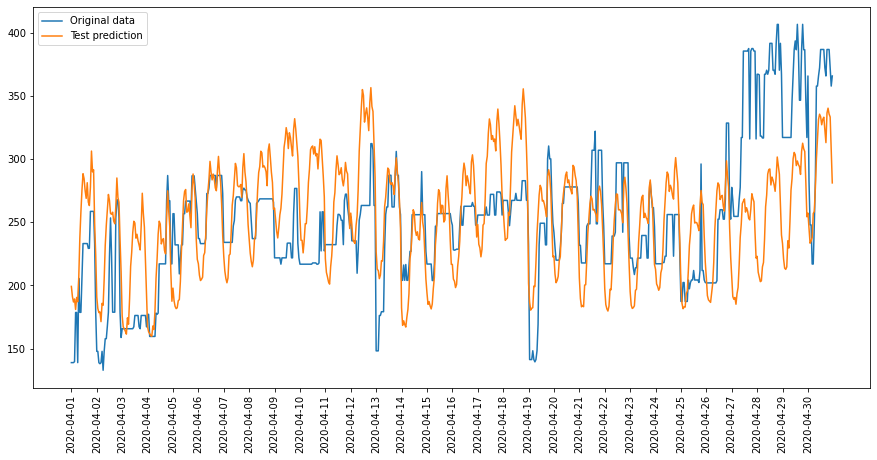

In [31]:
lista_fechas = pd.unique(precio_bolsa_test['date'])

plt.figure(figsize=(15,7))
plt.plot(testOriginalPlot,label='Original data')
plt.plot(testPredictPlot,label='Test prediction')
plt.xticks(ticks=np.arange(0, 720, step=24),labels=lista_fechas,rotation=90)
plt.legend()
plt.show()

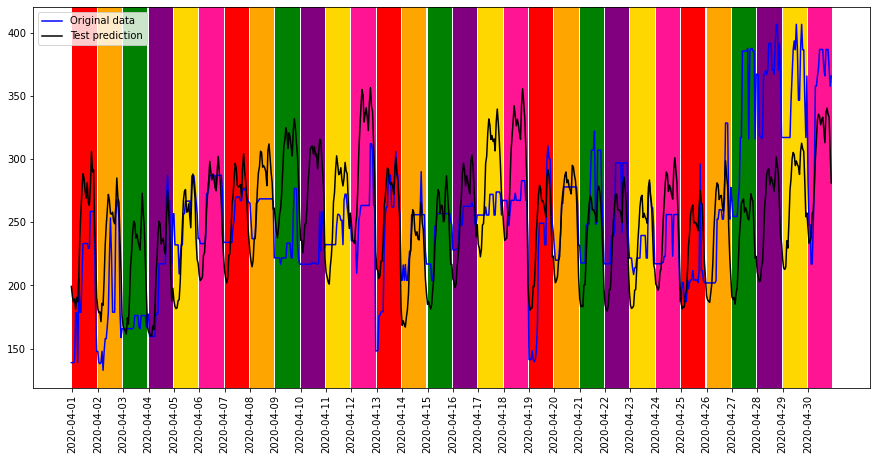

In [32]:
lista_fechas = pd.unique(precio_bolsa_test['date'])

fig, ax = plt.subplots(figsize=(15,7))
ax.plot(testOriginalPlot,label='Original data',color='blue')
ax.plot(testPredictPlot,label='Test prediction',color='black')
ax.set_xticks(ticks=np.arange(0, 720, step=24)+1)
ax.set_xticklabels(labels=lista_fechas,rotation=90)
day = 0
for i in range(0,720,24):
    ax.axvspan(i+1, i+24, facecolor=day_color[day%6])
    day += 1
ax.legend()
plt.show()

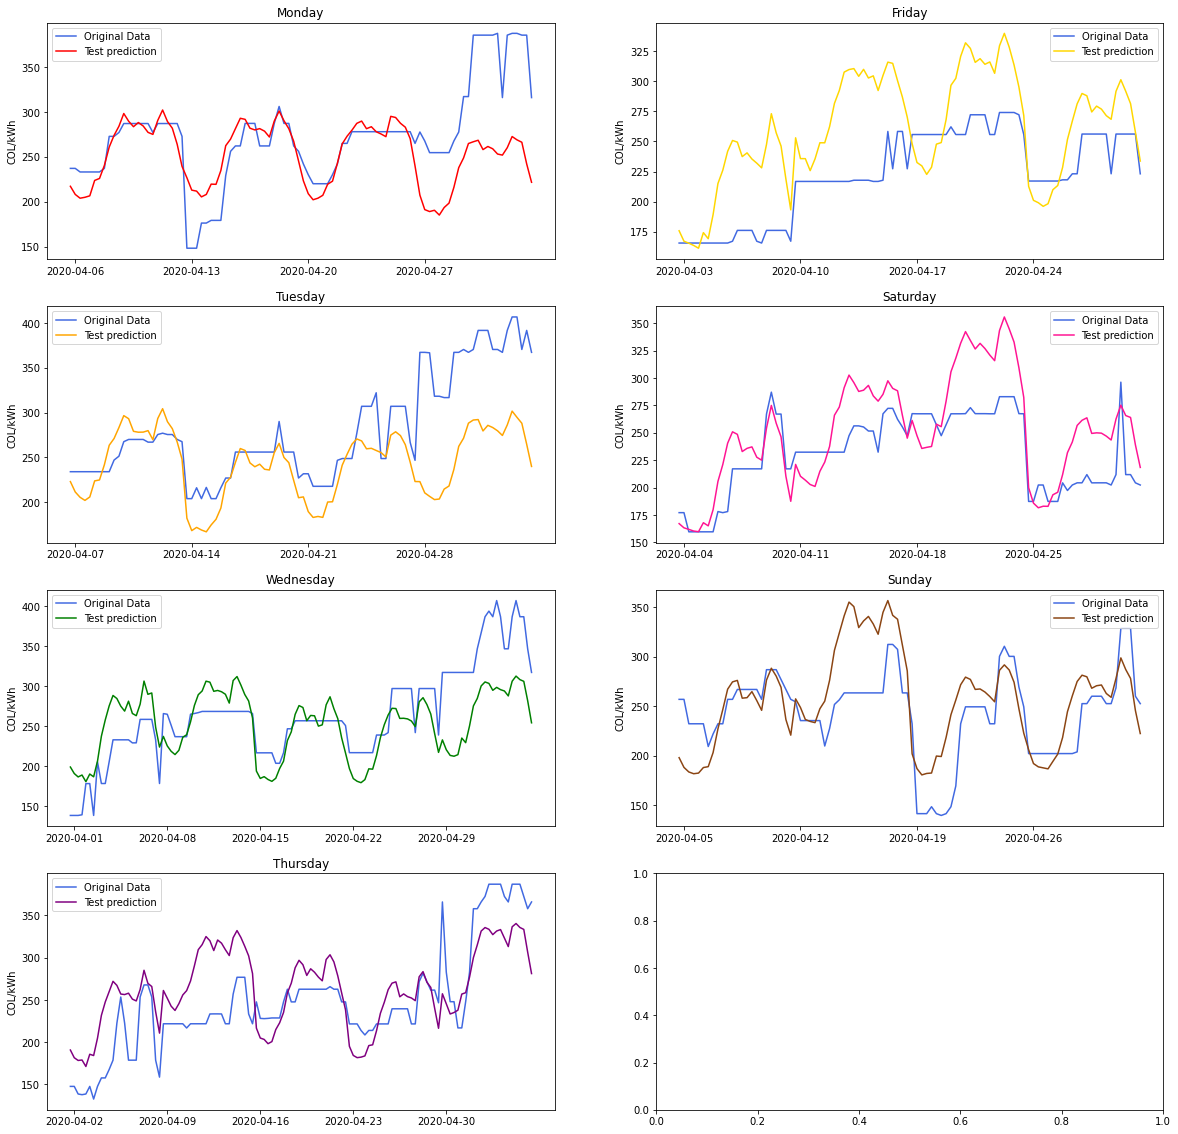

In [33]:
fig, axs = plt.subplots(4, 2, sharex='none',figsize=(10,7))
fig.set_size_inches(20,20)
k1 = 0
k2 = 0

for j,day in enumerate(Days):
    precio_bolsa_dia = precio_bolsa_test[precio_bolsa_test['day_of_week']==day]
    idxs = precio_bolsa_dia['idx'].values
    testPredict_filtrado = testPredict[idxs]
    
    testOriginalPlot = np.zeros((precio_bolsa_dia.shape[0],1))
    testOriginalPlot[:, :] = precio_bolsa_dia['$kWh'].values.reshape(-1,1)

    testPredictPlot = np.zeros((testPredict_filtrado.shape[0],1))
    testPredictPlot[:, :] = testPredict_filtrado
    
    lista_fechas = pd.unique(precio_bolsa_dia['date'])
    
    k1 = j
    if j > 3:
        k1 = j-4
        k2 = 1
    
    axs[k1,k2].plot(testOriginalPlot,label='Original Data',color='royalblue')
    axs[k1,k2].plot(testPredictPlot,label='Test prediction',color=day_color[j])
    axs[k1,k2].set_xticks(ticks=np.arange(0, len(lista_fechas)*24, step=24)+1)
    axs[k1,k2].set_xticklabels(labels=lista_fechas,rotation=0)
    
    axs[k1,k2].set_title(day)
    axs[k1,k2].legend()
    axs[k1,k2].set_ylabel('COL/kWh')